In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
from models.fcn import FCN
from models.fcn_potential import FCN_Potential
import pickle
import sde_lib
import os
from configs.fokker_planck import get_config

In [3]:
log_path = 'logs/fokker_planck'
log_name = 'fp_0.001'

config_path = os.path.join(log_path, log_name, 'config.pkl')
with open(config_path, 'rb') as file:
    config = pickle.load(file)

FileNotFoundError: [Errno 2] No such file or directory: 'logs/fokker_planck/fp_0.001/config.pkl'

In [6]:
config = get_config()

In [21]:
config.model.checkpoint_path = 'logs/fokker_planck/fp_0.001/checkpoints/best/epoch=10236--eval_loss_epoch=6.710.ckpt'

In [14]:
def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 500   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [17]:
samples = sample(config)

100%|██████████| 1000/1000 [00:12<00:00, 83.18it/s]


In [23]:
ckpt_path = config.model.checkpoint_path
pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
score_model = pl_module.score_model
pl_module.configure_sde(config)
pl_module = pl_module.eval()

In [24]:
from utils import generate_grid, extract_vector_field, compute_curl
n = 25    
X,Y = generate_grid(n=n)
t=0.
out_X, out_Y = extract_vector_field(pl_module, X, Y, t)

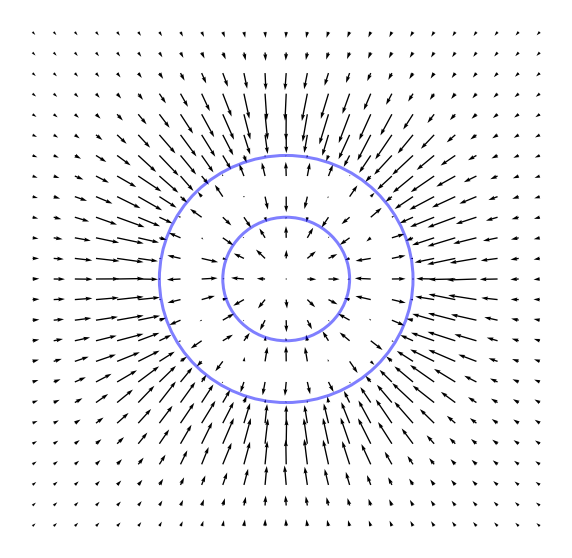

In [44]:
plt.figure(figsize=(10, 10))
plt.quiver(X,Y,out_X,out_Y)
circle1 = plt.Circle((0, 0), 1, color='b', fill=False, linewidth=3.0, alpha=0.5)
circle2 = plt.Circle((0, 0), 0.5, color='b', fill=False, linewidth=3.0, alpha=0.5)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.grid()
plt.axis('off')
plt.savefig('figures/score_field', dpi=300, facecolor='white')